In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch.nn as nn
import torch
from datetime import datetime
import pandas as pd
from transformers import CLIPProcessor, CLIPModel, AutoImageProcessor, AutoModel, AutoTokenizer
import numpy as np

from sentence_transformers import SentenceTransformer
from torch.utils.data import Dataset, DataLoader, random_split, Subset


from pathlib import Path
from PIL import Image


## IMPORT

In [7]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

#### DATA

In [3]:
!unzip "/content/drive/MyDrive/Data Science/tinyvlm/tinyvlm/data/image-description-marketplace-data.zip" -d "/content/flip_data_vlm"

Streaming output truncated to the last 5000 lines.
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Хаб_1163.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Хаб_1166.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Хаб_Promt_1243.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Хаб_Quadro_Express_1438.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Хаб_Quadro_Infix_1542.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Хаб_Universal_RS050_5850.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Цветной_чехол_на_IPhone_14_Pro_Max_с_функцией_MagS_881.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Цветной_чехол_на_IPhone_14_Pro_Max_с_функцией_MagS_882.jpg  
  inflating: /content/flip_data

##### RELOAD DATA

In [4]:
class ImageTitleWithClipDataset(Dataset):
    def __init__(self, data):
        """
        data: list of dicts with keys:
          - image_path
          - text
          - image_embedding (CLIP)
          - text_embedding (CLIP)
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        return (
            item["image_path"],         # PIL image will be loaded in training loop
            item["text"],               # text
            item["image_embedding"],    # CLIP image embedding (tensor)
            item["text_embedding"]      # CLIP text embedding (tensor)
        )

In [5]:
# Load the data from the .pt file
loaded_data = torch.load("/content/drive/MyDrive/Data Science/tinyvlm/tinyvlm/data/image_paths_with_clip_embeddings.pt")

# Initialize the dataset with the loaded data
dataset = ImageTitleWithClipDataset(loaded_data)


📝 Query Text: Sports Sports Male, Black, 44ru/M


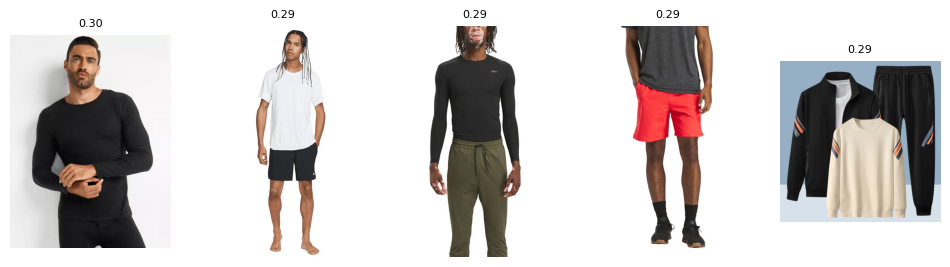


📝 Query Text: Teapot CT-0034


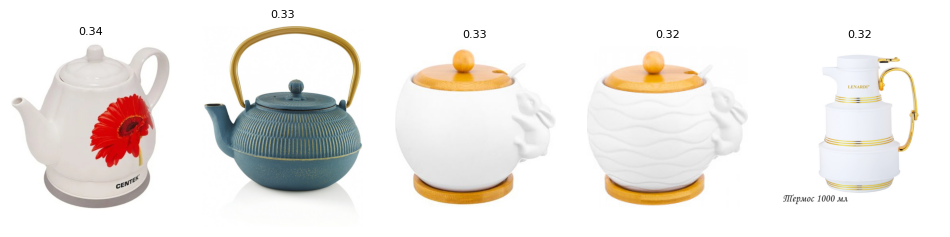


📝 Query Text: Transformer container "to go", purple


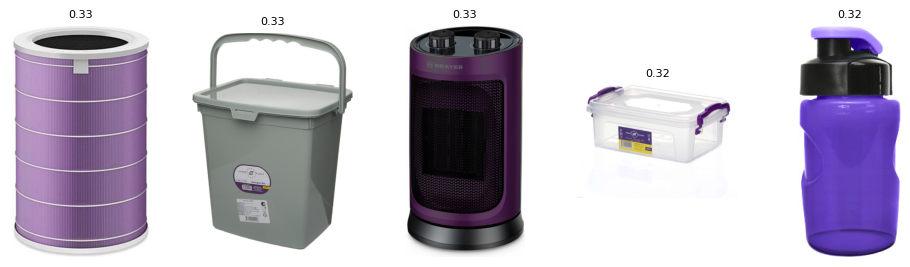


📝 Query Text: Vacuumor


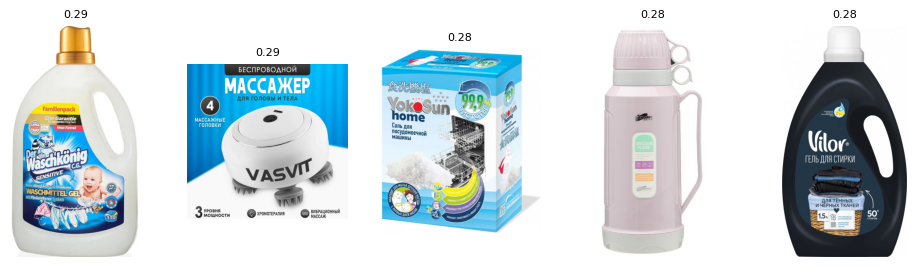


📝 Query Text: Women's sneakers are black


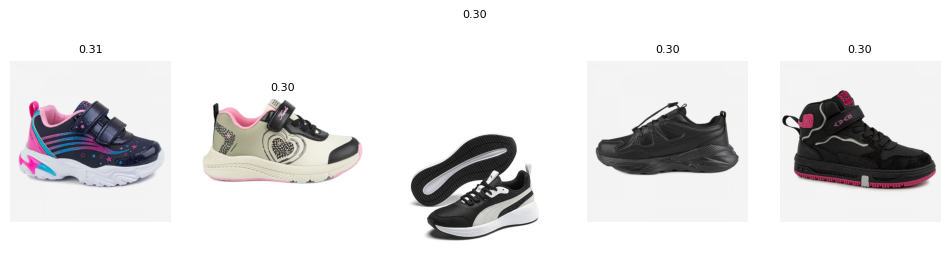

In [6]:
import random
from matplotlib import pyplot as plt
from PIL import Image
import torch.nn.functional as F

# --- Stack embeddings ---
all_image_embeddings = torch.stack([dataset[i][2] for i in range(len(dataset))])  # image embeddings
all_text_embeddings = torch.stack([dataset[i][3] for i in range(len(dataset))])   # text embeddings
all_texts = [dataset[i][1] for i in range(len(dataset))]
all_image_paths = [dataset[i][0] for i in range(len(dataset))]

# --- Normalize ---
all_image_embeddings = F.normalize(all_image_embeddings, dim=-1)
all_text_embeddings = F.normalize(all_text_embeddings, dim=-1)

# --- Pick 5 random text queries ---
num_queries = 5
query_indices = random.sample(range(len(dataset)), num_queries)

for q in query_indices:
    query_text = all_texts[q]
    query_embedding = all_text_embeddings[q].unsqueeze(0)  # (1, dim)

    # --- Compute text→image cosine similarities ---
    similarity_scores = (query_embedding @ all_image_embeddings.T).squeeze(0)

    # Top-5 most similar images
    topk = torch.topk(similarity_scores, k=5)
    top_indices = topk.indices.tolist()
    top_scores = topk.values.tolist()

    print(f"\n📝 Query Text: {query_text}")
    plt.figure(figsize=(12, 3))

    # Show 5 retrieved images
    for i, idx in enumerate(top_indices):
        plt.subplot(1, 5, i + 1)
        plt.imshow(Image.open(all_image_paths[idx]))
        plt.title(f"{top_scores[i]:.2f}", fontsize=8)
        plt.axis("off")

    plt.show()


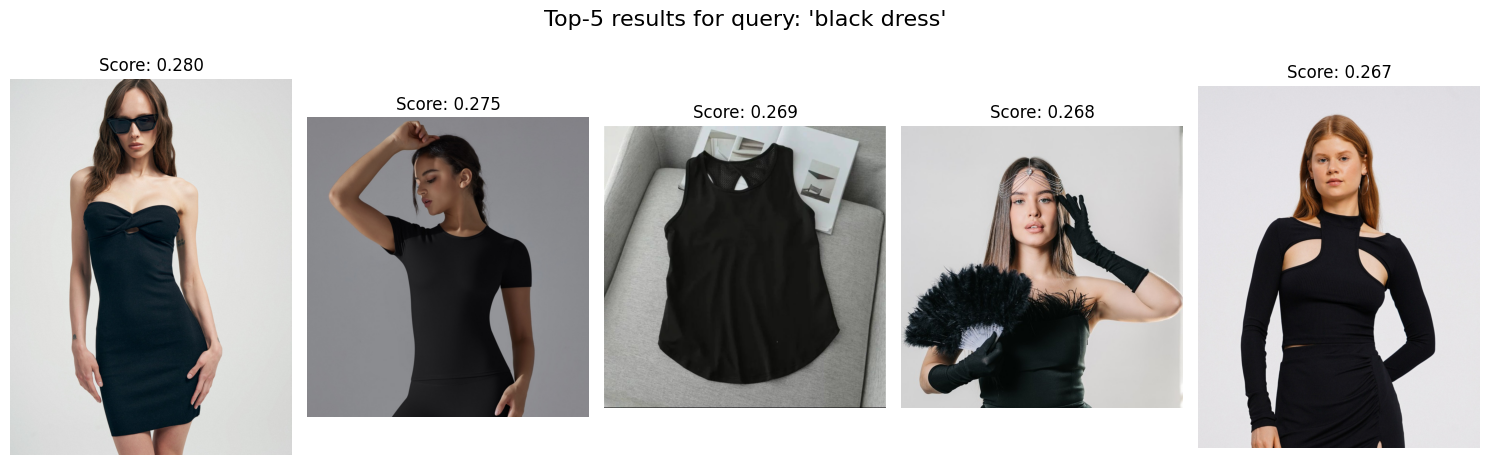

In [18]:
query_text_test = "toile"

query_text_test_processed = processor(text=query_text_test, return_tensors="pt")
query_embedding_test = model.get_text_features(**query_text_test_processed)

query_embedding_test = F.normalize(query_embedding_test, dim=-1)

similarity_scores = (query_embedding_test @ all_image_embeddings.T).squeeze(0)

# Top-5 most similar images
topk = torch.topk(similarity_scores, k=5)
top_indices = topk.indices.tolist()
top_scores = topk.values.tolist()


plt.figure(figsize=(15, 5))

for i, (idx, score) in enumerate(zip(top_indices, top_scores)):
    img_path = all_image_paths[idx]
    image = Image.open(img_path).convert("RGB")

    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Score: {score:.3f}")
    plt.axis("off")

plt.suptitle(f"Top-5 results for query: '{query_text_test}'", fontsize=16)
plt.tight_layout()
plt.show()